In [3]:
%load_ext autoreload

In [4]:
%autoreload

In [7]:
import pandas as pd
import numpy as np
#import nltk.tokenize
import itertools
import datetime
import torch

from pathlib import Path

from fastai import *
from fastai.text import *

from copy import copy, deepcopy
from enum import Enum

from graphviz import Digraph

import datetime

from sklearn.preprocessing import StandardScaler

# Deep Lyrics Generator - ULMFiT

## Set up instructions

### Create VM Instance

- Go to cloud.google.com, and create a new VM instance
- Disk size: 100GB or more
- CPUs + Memory: 2vCPUs, 7.5 GB Memory
- GPU: K80 (cheaper, less power) or P100 (2.5x more expensive, more power)
- Enable http, https traffic
- Boot: Deep learning pytorch instance

### Network configuration

In Google cloud platform:

- Go to Networking -> VPC Network, External IP addresses
- Select your VM instance and change the external address type from Ephemeral to Static
- Go to Networking -> VPC Network, Firewall Rules
- Add a new Rule, called Jupyter, ip ranges 0.0.0.0/0, protocols and ports tcp:8888, apply to all targets

### VM + Jupyter Setup

- SSH to VM
- Enlist into Github repo
- Run src/setup.sh
- Run jupyter notebook
- Open a google cloud shell
- Run gcloud init and answer the questions
- To set up a tunnel and run jupyter locally, run ```gcloud compute --project "<your project>" ssh --zone "<your zone>" "<your instance name>" -- -L 8888:localhost:8888```
- Open jupyter notebook in your local computer and have fun

### Notebook first run
Here are some steps to run the first time you use the notebook.

#### Tokens
To create the model's tokens with the correct train-test split, run ```src/data_collection/lm_data_lyrics.py -o path/to/save```. 
We recommend saving in data/models/{MODEL_NAME}. Alternatively, run the magic command below and replace the model name.

In [33]:
%run ../src/data_collection/lm_data_lyrics.py -o ../data/models/3.4-ULMFiT-Clas-108k

Numericalizing train.
Numericalizing valid.


#### Aggregate Audio Features

To create the model's audio features with the same train-test split as the language models, run `src/data/lm_data_audio.py -o path/to/save`

In [5]:
%run ../src/data_collection/lm_data_audio.py -o ../data/interim/msd-aggregate

## Process data for label encoding

We'll have to save the labels in a form that fastai likes

## Load Data

Now that we've created the tokens, let's load them into a `DataBunch` to train our LM further or generate text with a pre-trained LM.

In [8]:
init_model_name = '3.3-ULMFiT-108k'
INIT_MODEL_PATH = Path(f'../data/models/{init_model_name}')


model_name = '3.4-ULMFiT-Clas-108k'
MODEL_PATH = Path(f'../data/models/{model_name}')
MODEL_PATH.mkdir(exist_ok=True)

#### Mode Data

In [111]:
df_train = pd.read_csv('../data/interim/msd-aggregate/msd-aggregate-train.csv')
df_valid = pd.read_csv('../data/interim/msd-aggregate/msd-aggregate-valid.csv')

In [122]:
df_train.columns

Index(['track_id', 'analysis_sample_rate', 'audio_md5', 'danceability',
       'duration', 'end_of_fade_in', 'energy', 'key', 'key_confidence',
       'loudness', 'mode', 'mode_confidence', 'start_of_fade_out', 'tempo',
       'time_signature', 'time_signature_confidence', 'analyzer_version',
       'artist_7digitalid', 'artist_familiarity', 'artist_hotttnesss',
       'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_mbid', 'artist_name', 'artist_playmeid', 'genre', 'release',
       'release_7digitalid', 'song_hotttnesss', 'song_id', 'title',
       'track_7digitalid', 'year'],
      dtype='object')

In [126]:
train_feature = df_train['key']
valid_feature = df_valid['key']

In [127]:
np.save(MODEL_PATH/'train_lbl.npy', train_feature.values)
np.save(MODEL_PATH/'valid_lbl.npy', valid_feature.values)

In [128]:
data_clas = TextClasDataBunch.from_tokens(MODEL_PATH,
                                        bs=128,
                                        max_vocab=10000)

print(data_clas.train_ds.vocab_size)

10002


In [120]:
train_feature.cumsum().iloc[-1]/len(train_feature)

0.677112485459927

In [117]:
train_feature.head(20)

0     1
1     1
2     1
3     1
4     0
5     1
6     1
7     0
8     1
9     0
10    1
11    1
12    0
13    1
14    1
15    1
16    1
17    1
18    1
19    1
Name: mode, dtype: int64

In [118]:
len(learn.data.train_ds.labels)

86829

## Model setup

In [129]:
GPU = True

In [130]:
def text_classifier_learner(data:DataBunch, bptt:int=70, emb_sz:int=400, nh:int=1150, nl:int=3, pad_token:int=1,
               drop_mult:float=1., qrnn:bool=False,max_len:int=10*70, lin_ftrs:Collection[int]=None,
               ps:Collection[float]=None, **kwargs) -> 'TextClassifierLearner':
    "Create a RNN classifier."
    dps = default_dropout['classifier'] * drop_mult
    if lin_ftrs is None: lin_ftrs = [50]
    if ps is None:  ps = [0.1]
    ds = data.train_ds
    vocab_size, n_class = len(data.vocab.itos), len(np.unique(data.train_ds.labels))
    layers = [emb_sz*3] + lin_ftrs + [n_class]
    ps = [dps[4]] + ps
    model = get_rnn_classifier(bptt, max_len, n_class, vocab_size, emb_sz, nh, nl, pad_token,
                layers, ps, input_p=dps[0], weight_p=dps[1], embed_p=dps[2], hidden_p=dps[3], qrnn=qrnn)
    learn = RNNLearner(data, model, bptt, split_func=rnn_classifier_split, **kwargs)
    return learn

default_dropout = {'language': np.array([0.25, 0.1, 0.2, 0.02, 0.15]),
                   'classifier': np.array([0.4,0.5,0.05,0.3,0.4])}

In [131]:
def fbeta(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, beta:float=2, eps:float=1e-9, sigmoid:bool=True) -> Rank0Tensor:
    "Computes the f_beta between preds and targets"
    beta2 = beta**2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

In [132]:
learn = text_classifier_learner(data_clas, drop_mult=0.5, metrics=[fbeta])

In [133]:
learn.load_encoder(f'{model_name}_encoder_initializer')

In [17]:
# DOWNLOAD_MODEL_WEIGHTS = False
# weights_url = 'https://storage.googleapis.com/w210-capstone/3.2-ULMFiT-108k_best.pth'

# if DOWNLOAD_MODEL_WEIGHTS:
#     Path(MODEL_PATH/'models').mkdir(exist_ok=True)
#     download_url(weights_url, MODEL_PATH/f'models/{model_name}_best.pth', overwrite=True)

In [11]:
# def cpu_load(self, name:PathOrStr):
#     """Load model onto CPU that was trained on a GPU `name` from `self.model_dir`.
#        We need these because the fastai load function doesn't allow for a remapping of the storage location."""
#     self.model.load_state_dict(torch.load(self.path/self.model_dir/f'{name}.pth', map_location=lambda storage, loc: storage))

# setattr(RNNLearner, 'cpu_load', cpu_load) #monkey patch onto our RNNLearner

In [12]:
# if not GPU:
#     learn.cpu_load(f'{init_model_name}_best')
# else:
#     learn.load(f'{init_model_name}_best')

## Training

In [134]:
TRAIN = True

In [135]:
@dataclass
class SaveModel(LearnerCallback):
    """Save Latest Model"""
    def __init__(self, learn:Learner, model_name='saved_model'):
        super().__init__(learn)
        self.model_name = model_name
        self.model_date = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
        self.best_loss = None
        self.perplexity = []
        
    def on_epoch_end(self, epoch:int, metrics, last_metrics, **kwargs):
        loss, *_ = last_metrics
        perp = np.exp(loss)
        self.perplexity.append(perp)
        if self.best_loss == None or loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.model_name}_best')
        return False
    
    def on_train_end(self, epoch:int, **kwargs):
        self.learn.save(f'{self.model_name}_last')

In [136]:
save_callback = SaveModel(learn, model_name=f'{model_name}')

In [137]:
if TRAIN:
    learn.fit_one_cycle(1, 1e-2)

Total time: 06:26
epoch  train_loss  valid_loss  accuracy
1      2.415628    2.412177    0.129353  (06:26)



In [ ]:
if TRAIN:
    learn.unfreeze()
    learn.fit(5, 1e-3, callbacks=[save_callback])

epoch,train_loss,valid_loss,accuracy
1,2.413364,2.411640,0.132025
2,2.408372,2.414418,0.132578


In [40]:
print("best validation loss: ", learn.save_model.best_loss)

best validation loss:  0.62105566


#### Learning Loss

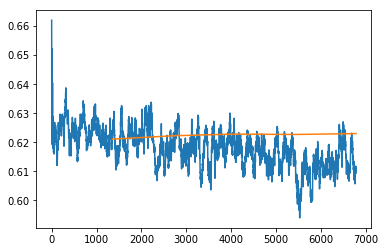

In [41]:
if TRAIN:
    learn.recorder.plot_losses()

In [27]:
learn.path = Path(MODEL_PATH)
learn.save(f'{model_name}')

## Experimentation (to delete)

In [69]:
F.sigmoid(Tensor([0.6878, 1.3804]))

/home/j_rosen_1392/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1120: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.6655, 0.7991])

In [92]:
learn.model.reset()
learn.model.eval()

SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(10002, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(10002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.1)
      (6): Linear(in_features=50, out_features=2, bias=T

In [107]:
learn.model.reset()
context = [1002,5000,2,2333]
context = LongTensor(context).view(-1,1).cuda()
#context = torch.autograd.Variable(context)


# forward pass the "context" into the model
result, *_ = learn.model(context)

In [108]:
F.softmax(result)

/home/j_rosen_1392/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.2537, 0.7463]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## Text Generation

In [72]:
def generate_step(learner, context, audio, context_length, temp=1):
    
    # FIX THIS
    audio_size = train_audio.feature_size

    model = learner.model
    
    if GPU:
        context = LongTensor(context[-context_length:]).view(-1,1).cuda()
    else:
        context = LongTensor(context[-context_length:]).view(-1,1).cpu()
    
    context = torch.autograd.Variable(context)
    
    model.reset()
    model.eval()

    if audio is None:
        audio_features = Tensor([0]*audio_size*len(context))\
        .view(-1, 1, audio_size).cuda()
    else:
        audio_features = np.tile(audio, len(context))
        audio_features = Tensor(audio_features).view(-1, 1, len(audio)).cuda()
        
    # forward pass the "context" into the model
    result, *_ = model(context, audio_features)
    result = result[-1]

    # set unk and pad to 0 prob
    # i.e. never pick unknown or pad
    result[0] = -np.inf
    result[1] = -np.inf

    # softmax and normalize
    probabilities = F.softmax(result/temp, dim=0)
    probabilities = np.asarray(probabilities.detach().cpu(), dtype=np.float)
    probabilities /= np.sum(probabilities) 
    return probabilities

def get_word_from_index(idx):

    return data_lm.valid_ds.vocab.textify([idx])


def print_words(context):
    for i in range(len(context)):
        
        step = context[i]

        word = data_lm.valid_ds.vocab.textify([step])

        if word == 'xeol':
            word = 'xeol \n'
        elif 'xbol' in word:
            word = 'xbol'
        elif word == 'xeos': 
            print(word)
            break
            
        print(word, end=' ')   

def generate_text(learner, seed_text=['xbos'], audio=None, max_len=500, GPU=False, context_length=20, beam_width=5, temp=1, verbose=True, graph=False):
    """Generates text with a given learner and returns best options.

    Parameters
    ----------
    learner : RNNLearner Language Model (RNNLearner.language_model())
        Fastai RNNLearner with tokenized language model data already loaded 
        
    seed_text : list or str
        List of strings where each item is a token. (e.g. ['the', 'cat']) or string that is split on white space

    max_len : int
        Number of words in generated sequence
        
    gpu : bool
        If you're using a GPU or not...
    
    context_length : int
        Amount of words that get input as "context" into the model. Set to 0 for no limit   
        
    beam_width : int
        How many new word indices to try out...computationally expensive
    
    verbose : bool
        If True, prints every possible context for a given word cycle

    Returns
    -------
    context_and_scores : list of lists
        Returns a sorted list of the entire tree search of contexts and their respective scores in the form:
        [[context, score], [context, score], ..., [context, score]]
    """
        
    if isinstance(seed_text, str):
        seed_text = data_lm.train_ds.vocab.numericalize(seed_text.split(' '))
    
    
    # Width for the beam search, to be externalized along with general decoding
    beam_width = beam_width
    
    if graph:
        optimization_graph = Digraph()

    # List of candidate word sequence. We'll maintain #beam_width top sequences here.
    # The context is a list of words, the scores are the sum of the log probabilities of each word
    context_and_scores = [[seed_text, 0.0]]
    
    # Loop over max number of words
    for word_number in range(max_len):
        print(f'Generating word: {word_number+1} / {max_len}')

        candidates = []
        
        # For each possible context that we've generated so far, generate new probabilities, 
        # and pick an additional #beam_width next candidates
        for i in range(len(context_and_scores)):
            # Get a new sequence of word indices and log-probability
            # Example: [[2, 138, 661], 23.181717]
            context, score = context_and_scores[i]
            
            # Obtain probabilities for next word given the context 
            probabilities = generate_step(learner, context, audio, context_length, temp)

            # Multinomial draw from the probabilities
            multinom_draw = np.random.multinomial(beam_width, probabilities)
            top_probabilities = np.argwhere(multinom_draw != 0).flatten()
                        
            #For each possible new candidate, update the context and scores
            for j in range(len(top_probabilities)):
                next_word_idx = top_probabilities[j]
                new_context = context + [next_word_idx]
                candidate = [new_context, (score - np.log(probabilities[next_word_idx]))]
                candidates.append(candidate)
                
                if graph:
                    optimization_graph.node("%d_%d" % (word_number, next_word_idx), "%s (%.2f)" % (get_word_from_index(next_word_idx), candidate[1]))
                    optimization_graph.edge("%d_%d" % (word_number - 1, context[len(context) -1]), "%d_%d" % (word_number, next_word_idx))
                
        #update the running tally of context and scores and sort by probability of each entry
        context_and_scores = candidates
        context_and_scores = sorted(context_and_scores, key = lambda x: x[1]) #sort by top entries

        context_and_scores = context_and_scores[:15] #for now, only keep the top 15 to speed things up but we can/should change this to beam_width or something else
        
        if verbose:
            for context, score in context_and_scores:
                print_words(context)
                print('\n')

    if graph:
        now = str(datetime.now())
        optimization_graph.render(directory='graph_viz/', filename=now, cleanup=True)
    return context_and_scores
    

In [96]:
df_valid.sample(5)

,track_id,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,...,artist_name,artist_playmeid,genre,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid,year
15330,TRGSQDW12903D0DCEB,22050,8a69bdfdc85ee52fbe5fa3be5a04f18f,0.0,111.28118,0.000,0.0,10,0.480,-10.260,...,The Constructus Corporation,-1,NaN,The Ziggurat,699902,0.440794,SOEPWKZ12A58A7F478,choose your own adventure,7764309,2002
15650,TRMJWEF128F9341FD3,22050,ecf2f9fd715ae282b91d78f4a081dadf,0.0,127.60771,0.202,0.0,2,0.016,-11.809,...,Oasis,1196,NaN,Live Lounge,557045,NaN,SOJBRZM12AB01891B6,Songbird,6161500,0
15660,TRAONKD12903CF239C,22050,bfffef67050ac8ad1154d2fa76b79f52,0.0,184.31955,0.148,0.0,5,0.234,-5.468,...,Paperboys,-1,NaN,No Cure For Life,689392,NaN,SOEMTQZ12AC468B402,In Between (Duets),7651007,2002
9493,TRATYKV12903CF956E,22050,af3f6e2b2ebb66b0726ee857d41f3836,0.0,299.49342,0.000,0.0,7,0.379,-3.673,...,French Horn Rebellion,-1,NaN,Up All Night EP,603749,NaN,SOHNFYO12AC3DF9DD7,Up All Night,6706053,2009
11817,TRFQNIS128F14809B7,22050,76b4db78cc8b0eacc77bf6a73b53a64f,0.0,215.30077,0.222,0.0,2,0.718,-15.471,...,Andrew Lloyd Webber,8487,NaN,The Likes Of Us,41256,0.215080,SOLTUMH12A6D4F8518,This Is My Time,438688,0


In [117]:
df_valid.iloc[7650]

track_id                                       TRCNUVO128F92E7CB7
analysis_sample_rate                                        22050
audio_md5                        f6ef05f8d81ec7bccffc081de3ca3ea7
danceability                                                    0
duration                                                  258.351
end_of_fade_in                                              0.996
energy                                                          0
key                                                             9
key_confidence                                              0.764
loudness                                                  -15.523
mode                                                            0
mode_confidence                                               0.7
start_of_fade_out                                         242.857
tempo                                                      78.805
time_signature                                                  4
time_signa

In [118]:
# mode == 1, loudness == -2.3,
# artist_hot == 0.57, artist_familiarity = 0.77, 
# song_hot == n/a
xx = valid_audio[9126]
# mode == 0, loudness == -15.5,
# artist_hot == 0.36, artist_familiarity = 0.51, 
# song_hot == 0
yy = valid_audio[7650] # mode == 0

In [127]:
final_scores = generate_text(learn, GPU=GPU,
                             seed_text='xbos xbol [verse-1]',
                             audio=xx,
                             max_len=80, context_length=200,
                             beam_width=3, verbose=False,
                             temp=1.5, graph=False)

Generating word: 1 / 80
Generating word: 2 / 80
Generating word: 3 / 80
Generating word: 4 / 80
Generating word: 5 / 80
Generating word: 6 / 80
Generating word: 7 / 80
Generating word: 8 / 80
Generating word: 9 / 80
Generating word: 10 / 80
Generating word: 11 / 80
Generating word: 12 / 80
Generating word: 13 / 80
Generating word: 14 / 80
Generating word: 15 / 80
Generating word: 16 / 80
Generating word: 17 / 80
Generating word: 18 / 80
Generating word: 19 / 80
Generating word: 20 / 80
Generating word: 21 / 80
Generating word: 22 / 80
Generating word: 23 / 80
Generating word: 24 / 80
Generating word: 25 / 80
Generating word: 26 / 80
Generating word: 27 / 80
Generating word: 28 / 80
Generating word: 29 / 80
Generating word: 30 / 80
Generating word: 31 / 80
Generating word: 32 / 80
Generating word: 33 / 80
Generating word: 34 / 80
Generating word: 35 / 80
Generating word: 36 / 80
Generating word: 37 / 80
Generating word: 38 / 80
Generating word: 39 / 80
Generating word: 40 / 80
Generatin

In [128]:
#print all of the final options of songs
for song, score in final_scores:
    print_words(song)
    print(score)
    print('\n')

xbos xxunk [verse-1] crave requiem xeol 
 xbol xeol 
 xbol so far away , i wish you were here today xeol 
 xbol and most of all i wish there was another way xeol 
 xbol i wish i could do this to me xeol 
 xbol xeol 
 xbol so you could leave here with me xeol 
 xbol much more than anything you meant to me xeol 
 xbol i wish i was dead xeol 
 xbol wish that i could go away xeol 
 xbol i wish i could 193.78870414374862


xbos xxunk [verse-1] crave requiem xeol 
 xbol xeol 
 xbol so far away , i wish you were here today xeol 
 xbol and most of all i wish there was another way xeol 
 xbol i wish i could do this to me xeol 
 xbol xeol 
 xbol so you could leave here with me xeol 
 xbol much more than anything you meant to me xeol 
 xbol i wish i was dead xeol 
 xbol wish that i could go away xeol 
 xbol i wish that i 193.80404884464744


xbos xxunk [verse-1] crave requiem xeol 
 xbol xeol 
 xbol so far away , i wish you were here today xeol 
 xbol and most of all i wish there was another way 